# Assignment 3

**Martin, Erik : 250660**  
**Seim, Håvard : 260699**  
**Group: L**  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import time
import copy

from IPython.display import clear_output, HTML
from matplotlib.animation import FuncAnimation

# 1. Problem Basic Graph

In [2]:
#       1  2  3  4  5  6
Adj = [[0, 1, 0, 0, 0, 0], # 1
       [0, 1, 1, 1, 0, 0], # 2
       [1, 1, 0 ,0, 1, 0], # 3
       [0, 0, 0, 0, 1, 1], # 4
       [0, 0, 1, 1, 0, 0], # 5
       [0, 0, 0, 1, 0, 0]] # 6

## 1. Convert the adjacency matrix to an adjacency list. The adjacent lists need to be in alphabetical order.
We are assuming that *in alphabetical order* means that the nodes are sorted by numbers, which gives this adjacency list:

| Node | Neighbors |
|------|-----------|
| 1    | 3         |
| 2    | 1, 2, 3   |
| 3    | 2, 5      |
| 4    | 2, 5, 6   |
| 5    | 3, 4      |
| 6    | 4         |


## 2. Draw the adjacency matrix in graph form.
We use networkx to draw the nodes and edges.

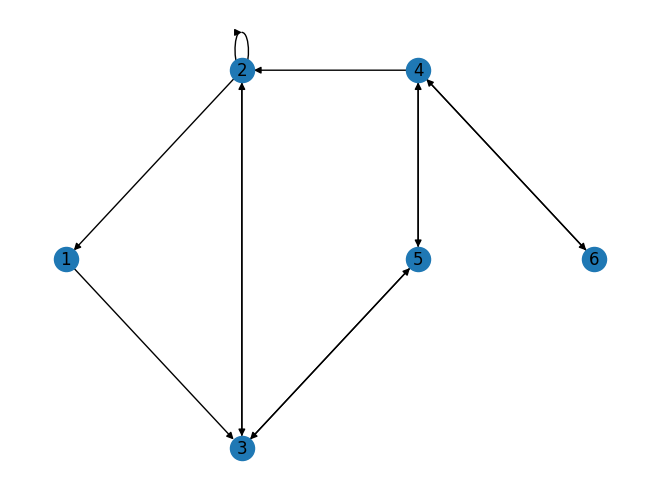

In [3]:
G = nx.DiGraph()
# Node 1
G.add_edge(1, 3)
# Node 2
G.add_edge(2, 1)
G.add_edge(2, 2)
G.add_edge(2, 3)
# Node 3
G.add_edge(3, 2)
G.add_edge(3, 5)
# Node 4
G.add_edge(4, 2)
G.add_edge(4, 5)
G.add_edge(4, 6)
# Node 5
G.add_edge(5, 3)
G.add_edge(5, 4)
# Node 6
G.add_edge(6, 4)

nx.draw(G, with_labels=True, pos={1: (0, -1), 2: (1, -0.5), 3: (1, -1.5), 4: (2, -0.5), 5: (2, -1), 6: (3, -1)})

## Make an adjacent list out of the graph in Figure 1 which also needs to be in alphabetical order.


| Node | Neighbors |
|------|-----------|
| A    | B         |
| B    | C, D      |
| C    | E, F      |
| D    | E, F      |
| E    | F, G, J   |
| F    | B, G, H, J|
| G    |           |
| H    | I         |
| I    |           |
| J    | I         |

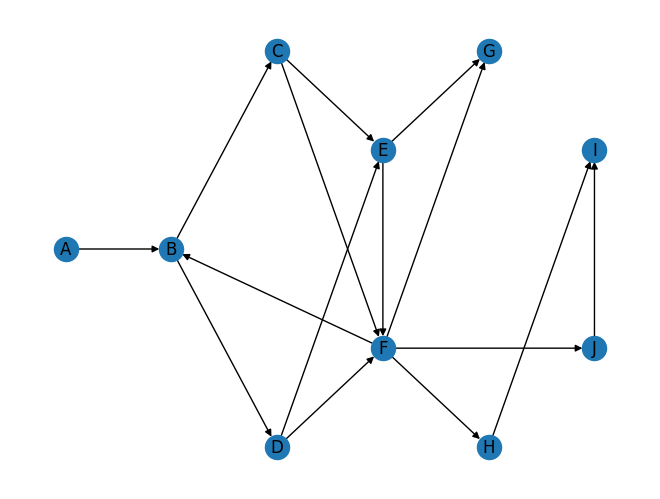

In [4]:
G = nx.DiGraph()

G.add_edge("A", "B")

G.add_edge("B", "C")
G.add_edge("B", "D")

G.add_edge("C", "E")
G.add_edge("C", "F")

G.add_edge("D", "E")
G.add_edge("D", "F")

G.add_edge("E", "F")
G.add_edge("E", "G")

G.add_edge("F", "B")
G.add_edge("F", "G")
G.add_edge("F", "H")
G.add_edge("F", "J")

G.add_edge("H", "I")

G.add_edge("J", "I")



nx.draw(G, with_labels=True,
        pos={
            "A": (0, 0),
            "B": (1, 0),
            "C": (2, 0.5),
            "D": (2, -0.5),
            "E": (3, 0.25),
            "F": (3, -0.25),
            "G": (4, 0.5),
            "H": (4, -0.5),
            "I": (5, 0.25),
            "J": (5, -0.25),
        }
)

## 1. b)
*Given a graph G = (V, E) and a source vertex s, execute both Depth-First Search (DFS) and Breadth-First Search (BFS) algorithms. Show the process by doing it manually on the graph depicted in Figure 1 with source vertex A (you can also do it with code, but then you need to include screenshots that clearly show the process). When visiting neighbors, visit them in alphabetical order. Each edge has a weight of 1. Don’t forget to incorporate the start and finish times.*

**The algorithms were implemented using the pseudocode from Introduction to Algorithms. BFS p. 595 and DFS p. 604**

## BFS
Point: BFS explores all neighbors at the present depth prior to moving on to the nodes at the next depth level. It uses a queue to keep track of the next vertex to explore, ensuring that vertices are explored in order of their distance from the starting point.

## DFS
Point: DFS explores as far as possible along each branch before backtracking. It uses a stack (either implicitly via recursion or explicitly using a data structure) to keep track of the next vertex to explore.

In [8]:
class Node:
    def __init__(
        self, name: str, weight: int = 0, neighbours: list[tuple[str, int]] = []
    ):
        self.name = name
        self.weight = weight
        self.neighbours: list[Node] = neighbours
        self.color = (
            "white"  # White before u.d time, gray between u.d and u.f and black after
        )
        self.pi: Node = None  # Predecessor node
        self.d = np.inf  # Discovery time
        self.f = np.inf  # Finishing time


    def __str__(self):
        neighbours = [
            (n.name, n.weight, n.color, n.pi.name if n.pi else None, n.d, n.f)
            for n in self.neighbours
        ]
        return f"{self.name}: {neighbours}"


class Graph:
    def __init__(
        self, nodes: list[Node] = [], pos: dict[str, tuple[int, int]] | None = None
    ):
        self.nodes = sorted(nodes, key=lambda x: x.name)
        self.pos = pos
        self.snapshot = []

        self.neighbour_to_node()

    def neighbour_to_node(self):
        for node in self.nodes:
            old_neighbours = node.neighbours
            node.neighbours = []
            for neighbour in old_neighbours:
                if isinstance(neighbour, Node):
                    continue
                node.neighbours.append(self.get(neighbour[0]))

    def get(self, name: str) -> Node | None:
        for node in self.nodes:
            if node.name == name:
                return node
        return None

    def names(self) -> list[str]:
        return [n.name for n in self.nodes]
    
    def pop_edge(self, node_name: str, neighbour_name: str) -> Node | None:
        node = self.get(node_name)
        old_neighbours = node.neighbours
        for i, n in enumerate(old_neighbours):
            if n.name == neighbour_name:
                return node.neighbours.pop(i)
        return None
                
    def add_edge(self, node_name: str, neighbour_name: str) -> int:
        node = self.get(node_name)
        neighbour = self.get(neighbour_name)
        if isinstance(node, Node) & isinstance(neighbour, Node):
            node.neighbours.append(neighbour)
            return 1
        return 0


    def graphical(self):
        G = nx.DiGraph()
        for node in self.nodes:
            G.add_node(node.name, color=node.color)
            for neighbour in self.get(node.name).neighbours:
                G.add_edge(node.name, neighbour.name)

        for edge in G.edges():
            print(edge)

        c = [self.get(node).color for node in G.nodes()]
        nx.draw(
            G,
            with_labels=True,
            node_color=c,
            font_color="red",
            pos=self.pos,
            edgecolors="tab:gray",
        )


def animate_graph(G: Graph):
    fig, ax = plt.subplots()

    def update(num):
        ax.clear()
        nodes = G.snapshot[num]
        nodes.graphical()

    ani = FuncAnimation(fig, update, frames=len(G.snapshot), interval=1000)
    return HTML(ani.to_html5_video())

('A', 'B')
('B', 'C')
('B', 'D')
('C', 'E')
('C', 'F')
('D', 'E')
('D', 'F')
('E', 'F')
('E', 'G')
('E', 'J')
('F', 'B')
('F', 'G')
('F', 'H')
('F', 'J')
('J', 'I')
('H', 'I')


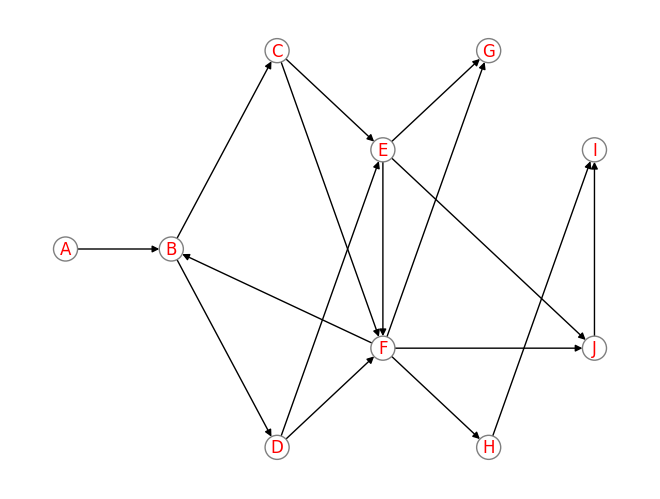

In [19]:

graph = Graph(
    nodes=[
        Node("A", 0, [("B", 1)]),
        Node("B", 0, [("C", 1), ("D", 1)]),
        Node("C", 0, [("E", 1), ("F", 1)]),
        Node("D", 0, [("E", 1), ("F", 1)]),
        Node("E", 0, [("F", 1), ("G", 1), ("J", 1)]),
        Node("F", 0, [("B", 1), ("G", 1), ("H", 1), ("J", 1)]),
        Node("G", 0, []),
        Node("H", 0, [("I", 1)]),
        Node("I", 0, []),
        Node("J", 0, [("I", 1)])
    ],
    pos={
        "A": (0, 0),
        "B": (1, 0),
        "C": (2, 0.5),
        "D": (2, -0.5),
        "E": (3, 0.25),
        "F": (3, -0.25),
        "G": (4, 0.5),
        "H": (4, -0.5),
        "I": (5, 0.25),
        "J": (5, -0.25),
    }
)

graph.graphical()

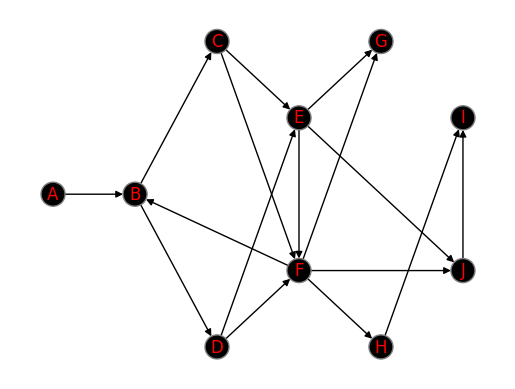

In [277]:
def bfs(G: Graph, s_string: str) -> tuple[list[str], Graph]:
    queue = []
    order = []
    s = G.get(s_string)
    s.color = "gray"
    s.d = 0
    queue.append(s)
    while len(queue) > 0:
        u = queue.pop(0)
        order.append(u.name)
        for neighbour in u.neighbours:
            v = G.get(neighbour.name)
            if v.color == "white":
                v.color = "gray"
                v.d = u.d + 1
                v.pi = u
                queue.append(v)
        u.color = "black"
        G.snapshot.append(copy.deepcopy(G))
    return order, G


breadth, G_copy = bfs(copy.deepcopy(graph), "A")
breadth

animate_graph(G_copy)

('A', 'B')
('B', 'C')
('B', 'D')
('C', 'E')
('C', 'F')
('D', 'E')
('D', 'F')
('E', 'F')
('E', 'G')
('E', 'J')
('F', 'B')
('F', 'G')
('F', 'H')
('F', 'J')
('J', 'I')
('H', 'I')
('A', 'B')
('B', 'C')
('B', 'D')
('C', 'E')
('C', 'F')
('D', 'E')
('D', 'F')
('E', 'F')
('E', 'G')
('E', 'J')
('F', 'B')
('F', 'G')
('F', 'H')
('F', 'J')
('J', 'I')
('H', 'I')
('A', 'B')
('B', 'C')
('B', 'D')
('C', 'E')
('C', 'F')
('D', 'E')
('D', 'F')
('E', 'F')
('E', 'G')
('E', 'J')
('F', 'B')
('F', 'G')
('F', 'H')
('F', 'J')
('J', 'I')
('H', 'I')
('A', 'B')
('B', 'C')
('B', 'D')
('C', 'E')
('C', 'F')
('D', 'E')
('D', 'F')
('E', 'F')
('E', 'G')
('E', 'J')
('F', 'B')
('F', 'G')
('F', 'H')
('F', 'J')
('J', 'I')
('H', 'I')
('A', 'B')
('B', 'C')
('B', 'D')
('C', 'E')
('C', 'F')
('D', 'E')
('D', 'F')
('E', 'F')
('E', 'G')
('E', 'J')
('F', 'B')
('F', 'G')
('F', 'H')
('F', 'J')
('J', 'I')
('H', 'I')
('A', 'B')
('B', 'C')
('B', 'D')
('C', 'E')
('C', 'F')
('D', 'E')
('D', 'F')
('E', 'F')
('E', 'G')
('E', 'J')
('F', 'B')

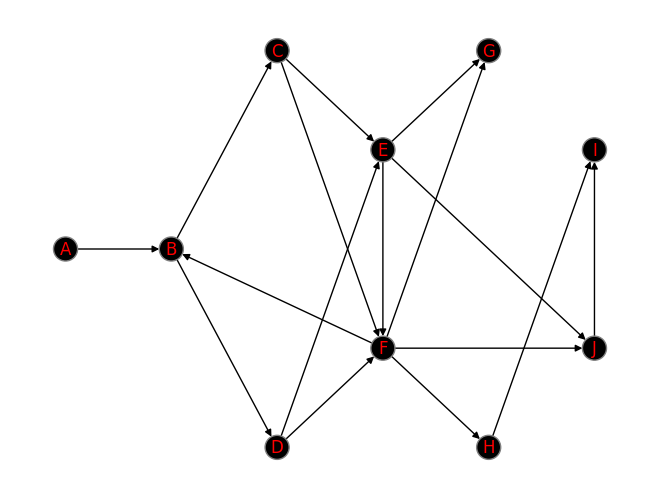

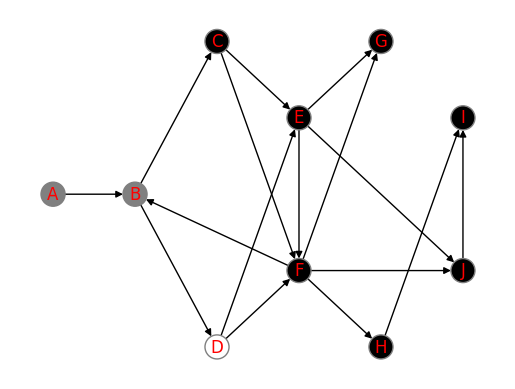

In [27]:
def dfs(G: Graph) -> Graph:
    """Algorithm for depth first search
    
    Args:
        G: Dictionary of nodes as key and list of (neighbour, weight) as value.

    Returns:
        A LIFO stack.
    """
    for u in G.nodes:
        u.color = "white"
        u.pi = None
        u.d = 0
        u.f = 0
    time = 0
    for u in G.nodes:
        if u.color == "white":
            G.snapshot.append(copy.deepcopy(G))
            dfs_visiting(G, u, time)
    return G



def dfs_visiting(G: Graph, u: Node, time: int = 0):
    time = time + 1
    u.d = time
    u.color = "gray"
    for v in G.get(u.name).neighbours:
        if v.color == "white":
            v.pi = u
            G.snapshot.append(copy.deepcopy(G))
            dfs_visiting(G, v, time)
    u.color = "black"
    time = time+1
    u.f = time


res = dfs(copy.deepcopy(graph))
res.graphical()

animate_graph(res)

## 1. c)
Removing the edge from F to B makes the graph directed and acyclic. 

In [32]:
def topological(G: Graph) -> list:
    result = []
    dfs(G)
    nodes = sorted(G.nodes, key = lambda x: x.f, reverse=True)
    for node in reversed(nodes):
        result.append(f"{node.name}: {node.f}")
    return result

c_graph = copy.deepcopy(graph)
c_graph.pop_edge("F", "B")
print(topological(c_graph))


['A: 2', 'B: 3', 'D: 4', 'C: 4', 'E: 5', 'F: 6', 'J: 7', 'H: 7', 'G: 7', 'I: 8']


## 1. d)


# 2. Problem Cable Network

# 3. Problem Finding Champion

# 4. Problem Shortest Path

# 5. Problem Maximum Flow

Correction

For problem 5 b) it is sufficient to only show some steps and the final result. There is no need to make the report very long.
If you implement the algorithm and use it to solve the problem than this solution is also valid. In your report you should show the main part of the implementation and a reference to your github repo, if you have one.
